# KMeans Clustering

By: William Duquette

Date: 1/26/2023

This notebook analyzes and clusters wines based on various features commonly used to measure the quality of wines. To do this clustering, we use KMeans, an unsupervised algorithm. Although we typically use this algorithm when we do not necessarily have ``targets," in this paper, we will see how pure our clusters are. What is meant by purity, in this case, is whether the clusters our algorithm form have all one kind of wine. We seek to understand how well the clusters formed using the explanatory variables correlate with the response variables. Using Gini Impurity as our measure of the algorithm's performance, we find that the KMeans algorithm works exceptionally well in clustering wines in a way that maintains purity.

In [1]:
# Import Necessary Libraries
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from statistics import mean
from matplotlib import cm
from scipy import linalg as la
import sys

cmap = cm.get_cmap('gnuplot')

<ipython-input-1-c4832539a24b>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gnuplot')


## KMeans v. KMeans++

KMeans is a classic algorithm in unsupervised machine learning. Like most areas of computer science, there have been improvements to the algorithm. One such improvement is the KMeans++ algorithm (we will go into more detail below). Using an example set, we hope to compare KMeans++ to its predecessor. The data consists of (x,y) pairs to help us see how the basic algorithm works. The data is stored in GitHub (imported from the link).

In [2]:
urlP = "https://raw.githubusercontent.com/wjduq/Wine_Cluster_Analysis/main/data.txt"
dfP = pd.read_csv(urlP, sep = ",")

Below is a scatter plot that shows what our data looks like. There are clearly four clusters of points in this data.

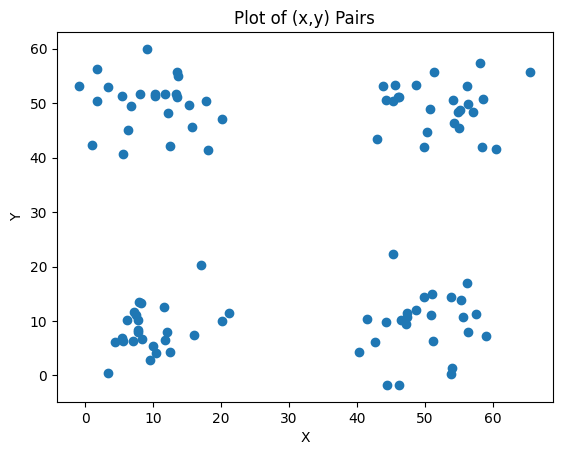

In [3]:
plt.scatter(dfP["X"], dfP["Y"])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Plot of (x,y) Pairs")
plt.show()

First, we define our basic KMeans algorithm. This algorithm will group points with other points that are similar to them. This is done in a relatively simple algorithm. The code can be seen below, but an outline will be provided here:

- Initialization: randomly place k centers
-Repeat: (1) Assignment phase in which we map each sample (point) to its closest center. (2) Update phase in which we move each center to the mean of its assigned samples

This algorithm will iterate until no changes are made to the center locations.


In [4]:
def kMeans(k, df):

  '''
  Inspired by code from  Stephan Marsland

  Author: William Duquette

  PARAMETERS:
  k - the number of clusters

  df - the data frame that is used to build our model or the training data


  RETURN VALUE: centers location, MSE, iterations, and clusters

  The function below is the K-Means Function. It fits clusters to the points. First the algorithm
  assigns clusters to random points in the data. Then it computes the distances to all of the data
  points in our data set and assings each data point to a cluster. Once this happens we move the
  clusters to be to the mean of its assigned samples. We then repeat this process until the clusters
  stop moving.
  '''

  # Convert data into numpy
  datanp = df.to_numpy()
  data = np.shape(datanp)[0]

  # Find min and max
  min = datanp.min(axis = 0)
  max = datanp.max(axis = 0)
  dim = np.shape(datanp)[1]
  centers = np.random.rand(k, dim) * (max - min) + min
  oldCenters = np.random.rand(k, dim) * (max - min) + min

  iterations = 0
  pastDiff = 0
  while np.sum(np.sum(oldCenters - centers)) != pastDiff: # Make sure that centers are not same as past
    pastDiff = np.sum(np.sum(oldCenters - centers))

    oldCentres = centers.copy()
    iterations += 1

    # Compute distances
    distances = np.ones((1,data))*np.sum((datanp-centers[0,:])**2,axis=1)
    for j in range(k-1):
      distances = np.append(distances,np.ones((1,data))*np.sum((datanp-centers[j+1,:])**2,axis=1),axis=0)

    # Identify the closest cluster
    cluster = distances.argmin(axis=0)
    cluster = np.transpose(cluster*np.ones((1,data)))

    # Update the cluster centers
    for j in range(k):
      thisCluster = np.where(cluster==j,1,0)
      if sum(thisCluster)>0:
        centers[j,:] = np.sum(datanp*thisCluster,axis=0)/np.sum(thisCluster)


  # Compute Error
  errors = 0

  for i in range(len(datanp)):
    dPoint = datanp[i]
    labelCenter = centers[int(cluster[i])]
    dist = ((dPoint[0] - labelCenter[0])**2 + (dPoint[1] - labelCenter[1])**2) #Compute Distance from the center
    errors += dist

  return (centers, errors/(2*len(datanp)), iterations, cluster) # Return centers, MSE, iterations, and clusters

A small sub-experiment we will conduct is comparing KMeans++ to the KMeans algorithm.

These two algorithms are similar. The only difference between the two is in the initialization step. In KMeans++, we select our first center randomly (random point), but instead of picking the following centers randomly, we try to pick points for our centers far away from our previous centers. Although this takes more time in the initialization step, it reduces the number of iterations the algorithm has to run to find the center's location.

In [5]:
def kMeansP(k, df):

  '''
  Inspired by code from  Stephan Marsland

  Author: William Duquette

  PARAMETERS:
  k - the number of clusters

  df - the data frame that is used to build our model or the training data


  RETURN VALUE: centers location, MSE, iterations, and clusters

  The function below is the K-Means++ Function. This algorithm is slightly different than the typical
  KMeans algorithm, although it is not entirely different. Essentially, KMeans++ initializes the centers
  in a smarter way than KMeans. KMeans typically will either randomly select locations within a certian
  range or randomly select points, but this could lead to bad distribution of points among each center.
  KMEans++ selects the first center randomly. Then it selects points that are distant from one another.
  It is true that this initialization step is slightly slower than picking random points, it reduces
  the number of iterations necessary for the algorithm to find the optimal solution.

  After the KMeans++ algorithm initializes the centers it will compute the distances to all of the data
  points in our data set and assings each data point to a cluster. Once this happens we move the clusters
  to be to the mean of its assigned samples. We then repeat this process until the clusters stop moving.
  '''

  # Convert data into numpy
  datanp = df.to_numpy()
  data = np.shape(datanp)[0]

  # Find min and max
  min = datanp.min(axis = 0)
  max = datanp.max(axis = 0)
  dim = np.shape(datanp)[1]


  # initialize points KMeans ++
  c = []
  c.append(datanp[np.random.randint(datanp.shape[0]), :]) # Select first center randomly

  for center in range(k - 1): # Initalize k centers
    distance = []
    for i in range(datanp.shape[0]):
      point = datanp[i, :]
      d = int(sys.maxsize) # max out int so it does interfere with calculations

      for j in range(len(c)):
        temp_dist = np.sum((point - c[j])**2) # Compute distances between point and centers
        temp_dist2 = float(temp_dist)
        d2 = float(d)
        #select min distance
        if d2 < temp_dist2:
          d = d2
        else:
          d = temp_dist2
      distance.append(d)

  ###### Crucial step: this selects the points that are furthest from our current centers
  ###### This will be our next center
    distance = np.array(distance)
    next_c = datanp[np.argmax(distance), :] # crucial argmax is used in this case
    c.append(next_c)
    distance = []

  centers = np.array([np.array(x) for x in c])
  oldCenters = np.random.rand(k, dim) * (max - min) + min

  iterations = 0
  pastDiff = 0
  while np.sum(np.sum(oldCenters - centers)) != pastDiff: # Make sure that centers are not same as past
    pastDiff = np.sum(np.sum(oldCenters - centers))

    oldCentres = centers.copy()
    iterations += 1

    # Compute distances
    distances = np.ones((1,data))*np.sum((datanp-centers[0,:])**2,axis=1)
    for j in range(k-1):
      distances = np.append(distances,np.ones((1,data))*np.sum((datanp-centers[j+1,:])**2,axis=1),axis=0)

    # Identify the closest cluster
    cluster = distances.argmin(axis=0)
    cluster = np.transpose(cluster*np.ones((1,data)))

    # Update the cluster centers
    for j in range(k):
      thisCluster = np.where(cluster==j,1,0)
      if sum(thisCluster)>0:
        centers[j,:] = np.sum(datanp*thisCluster,axis=0)/np.sum(thisCluster)


  # Compute Error
  errors = 0

  for i in range(len(datanp)):
    dPoint = datanp[i]
    labelCenter = centers[int(cluster[i])]
    dist = ((dPoint[0] - labelCenter[0])**2 + (dPoint[1] - labelCenter[1])**2) #Compute Distance from the center
    errors += dist

  return (centers, errors/(2*len(datanp)), iterations, cluster) # Return centers, MSE, iterations, and clusters

Below we can see a small example of how the two algorithms compare. When these subsequent blocks of code are run and produce a graph, the centers that KMeans and KMeans++ produce will likely be similar, if not visually identical. However, over multiple iterations, it becomes clear that the KMeans++ algorithm is far superior to the original KMeans++ algorithm.

In [6]:
centers, MSE, iterations, clusters = kMeans(4, dfP)
centersP, MSEP, iterationsP, clustersP = kMeansP(4, dfP)

In [7]:
print("Error for this value of k is (KMeans) " + str(MSE))
print("Error for this value of k is (KMeans++) " + str(MSEP))

Error for this value of k is (KMeans) 122.15832938216263
Error for this value of k is (KMeans++) 25.38899473379298


In [8]:
# Calculate the x and y values for the centers
centersx = [i[0] for i in centers]
centersy = [i[1] for i in centers]
centersxP = [i[0] for i in centersP]
centersyP = [i[1] for i in centersP]

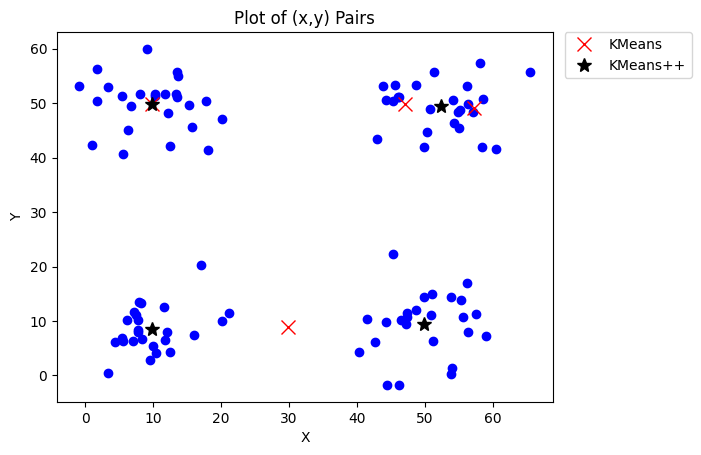

In [9]:
plt.scatter(dfP["X"], dfP["Y"], c = "blue")

plt.plot(centersx, centersy, marker = "x", ls = "none", c = "red", ms = 10, label = "KMeans")
plt.plot(centersxP, centersyP, marker = "*", ls = "none", c = "black", ms = 10, label = "KMeans++")
plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right', borderaxespad=0) # legend placement
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Plot of (x,y) Pairs")

plt.show()

As previously mentioned, it is likely that across one iteration KMeans and KMeans++ appear the same. However, as shown below, the KMeans++ distinguishes itself over multiple iterations as the superior algorithm. Below are several functions that we will use to show this distinction:

- compareKVP: creates plots that visually compare the two approaches
- averageMSE: Computes the average MSE for each approach for several iterations

In [10]:
def compareKvP(k, df, limit):
  '''
  Author: William Duquette

  PARAMETERS:
  k - the number of clusters

  df - the data frame that is used to build our model or the training data

  limit - limit to the number of iterations (number of plots)


  RETURN VALUE: NULL

  The function below is compares the center locations of KMeans and KMeans++
  and outputs plots that place the center locations for both algorithms
  on the plot so that the user can see the difference. This will compute
  the number of plots equal to the limit.
  '''

  count = 0
  while True:
    centers, MSE, iterations, clusters = kMeans(k, df)
    centersP, MSEP, iterationsP, clustersP = kMeansP(k, df)

    # Calculate the x and y values for the centers
    centersx = [i[0] for i in centers]
    centersy = [i[1] for i in centers]
    centersxP = [i[0] for i in centersP]
    centersyP = [i[1] for i in centersP]

    plt.scatter(df["X"], df["Y"], c = "blue")
    plt.plot(centersx, centersy, marker = "x", ls = "none", c = "red", ms = 10, label = "KMeans")
    plt.plot(centersxP, centersyP, marker = "*", ls = "none", c = "black", ms = 10, label = "KMeans++")
    plt.legend(bbox_to_anchor=(1.28, 1), loc='upper right', borderaxespad=0) # legend placement
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Plot of (x,y) Pairs")

    plt.show()

    count = count + 1 # prevent infinite loop
    if count == limit:
      break

In [11]:
def averageMSE(k, df, limit):
  '''
  Author: William Duquette

  PARAMETERS:
  k - the number of clusters

  df - the data frame that is used to build our model or the training data

  limit - limit to the number of iterations (number of time functions are run)

  Warning: This is an extremely computationly expensive and takes an extended
  amount of time if limit is set to high


  RETURN VALUE: NULL

  The function runs both the Kmeans and Kmeans++ algorithms and computes their MSEs.
  The MSEs are summed and the divided by the number of iterations. This will allow us
  to see the average MSE for each approach to Kmeans.
  '''
  iterations = 0
  KM = 0
  KMP = 0
  while True:
    centers, MSE, iterations, clusters = kMeans(k, df)
    centersP, MSEP, iterationsP, clustersP = kMeansP(k, df)
    KM += MSE
    KMP += MSEP

    iterations += 1
    if iterations == limit:
      break
  print("KMeans: " + str(KM/limit) + ". KMeans++: " + str(KMP/limit) + ".")

As shown below, the average MSE for the KMeans++ algorithm is significantly smaller than the original MSE. This can become clear when looking at the data graphically. See the produced plots, and notice that the algorithms frequently chose virtually identical points. However, occasionally, the original KMeans algorithm places centers in suboptimal locations, a function of randomly placing the points. In contrast, the KMeans++ algorithm always places the centers in the optimal locations, which shows us the superiority of the KMeans++ algorithm.

In [12]:
averageMSE(4, dfP, 15)

KMeans: 605.735136684951. KMeans++: 297.8975382098376.


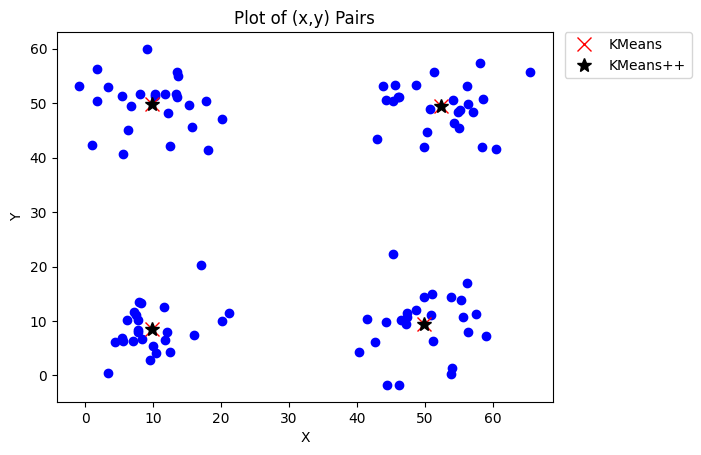

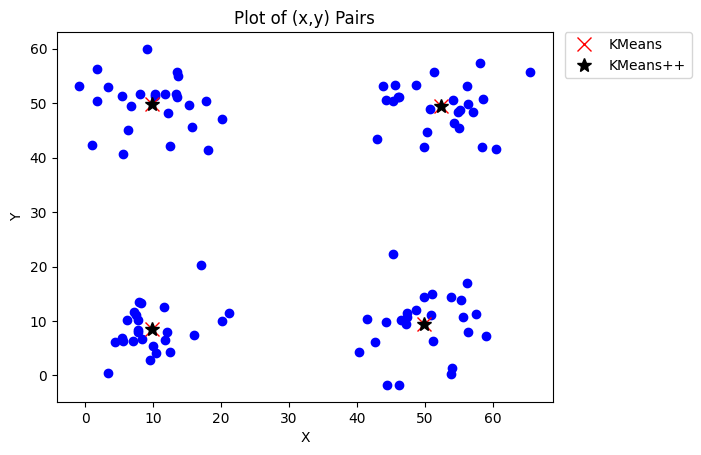

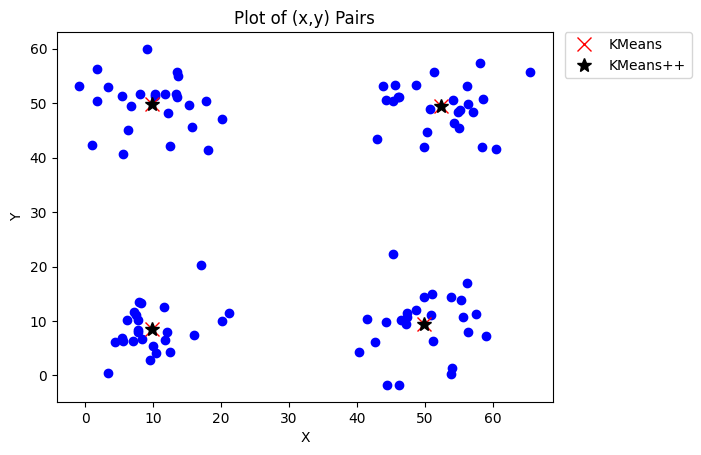

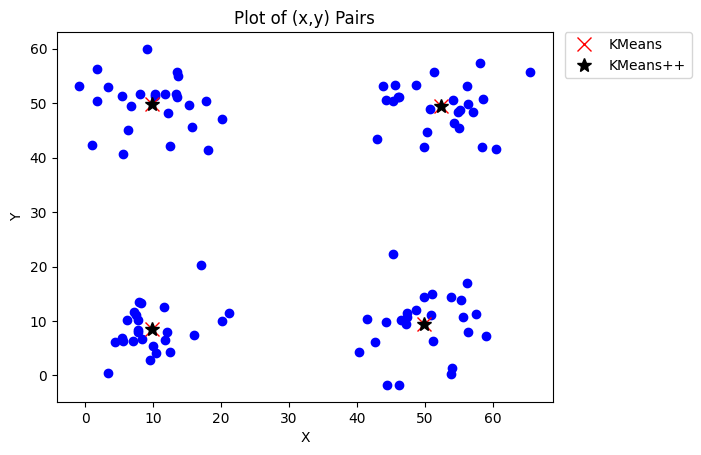

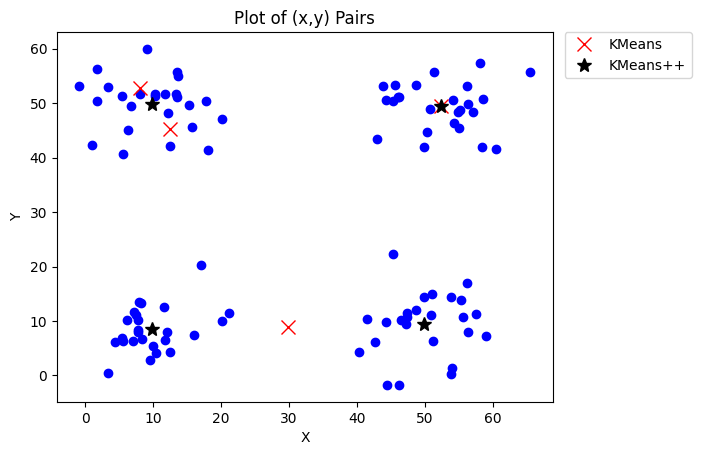

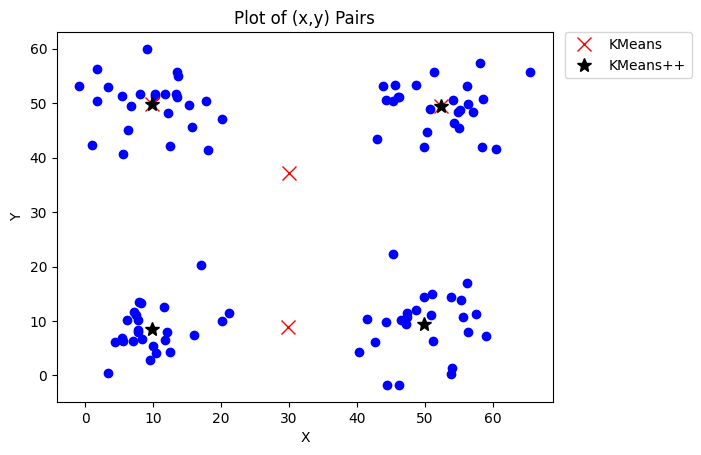

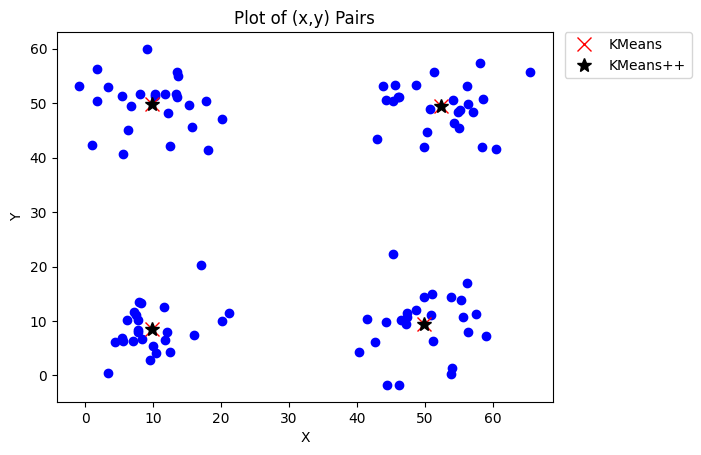

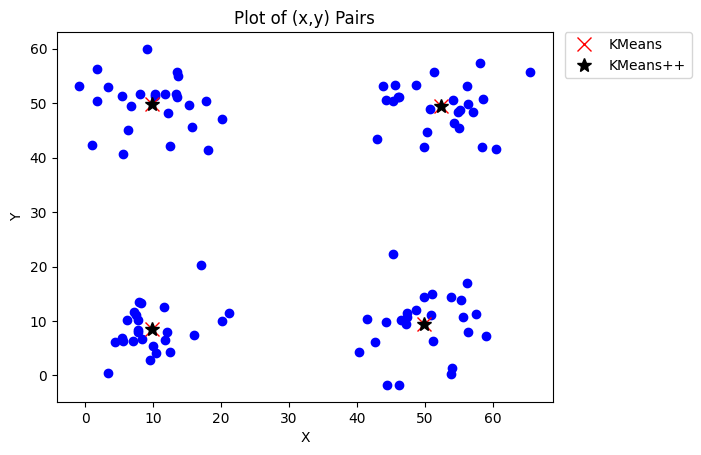

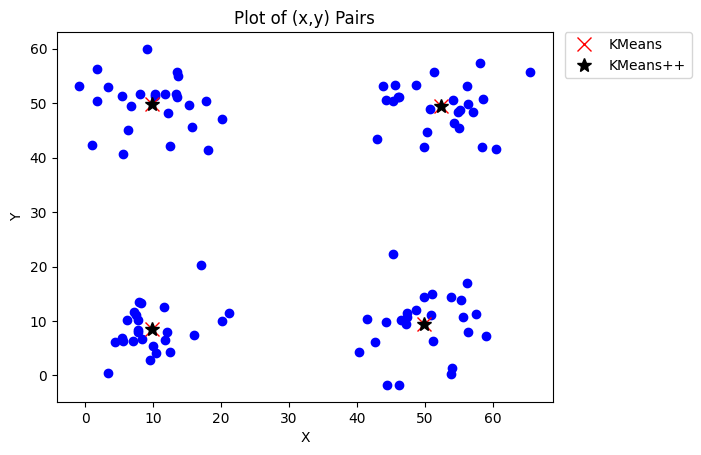

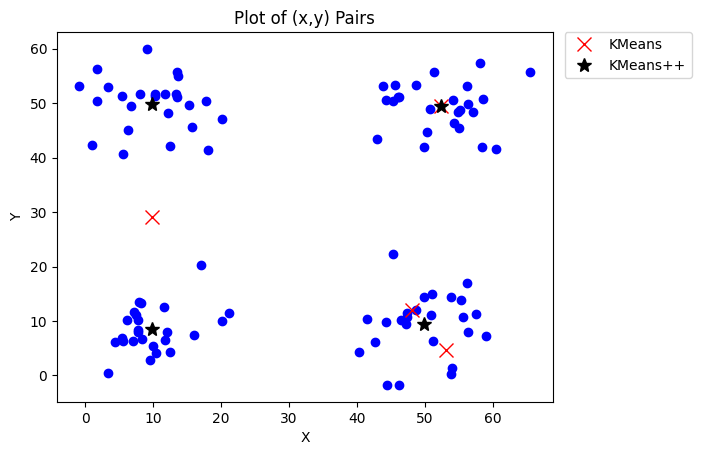

In [13]:
compareKvP(4, dfP, 10)

A common and important question is how many clusters should be used. Clearly, in the example data above, we need four clusters. However, real-world data is very rarely clustered so nicely. As a result, knowing how many clusters to use can be challenging. This is when making a plot of the MSE v k can be extremely useful. Within this plot, we hope to find the elbow. There is no formal definition of the elbow, but generally, it is where the MSE v k line starts to level off, which signals to us that this is the natural clustering of the data. Below is a function that makes such a plot.

Note: This function will not tell you the location of the elbow but will give you the plot to do so.

In [14]:
def MSEPlot(maxK, df):
  '''
  Author: William Duquette

  PARAMETERS:
  maxK - the maximum value of K possible

  df - the data frame that is used to build our model or the training data


  RETURN VALUE: NULL
  Output: MSE Elbow Plot

  Note: This uses KMeans++

  The function below trains models up to the max value of k. The plot shows
  the MSE on the y axis and the possible values of k on the x axis.
  '''
  errorL = []
  for k in range(1,maxK + 1): #iterate through all possible values of k (up to max k)
    output = kMeansP(k, df) # run model to find MSE
    errorL.append(output[1])

  #Create plot
  ks = [k for k in range(1, maxK + 1)]
  plt.plot(ks, errorL)
  plt.xlabel("K")
  plt.ylabel("MSE")
  plt.title("MSE v. K")
  plt.show()

Below is the elbow plot of the example data. Again, we can see that there are four clusters of data. However, for example, we will suppose that we are not entirely sure how many clusters are necessary. Using the elbow plot below, we would see that four is the correct number of clusters to use, as that is the location of the elbow.

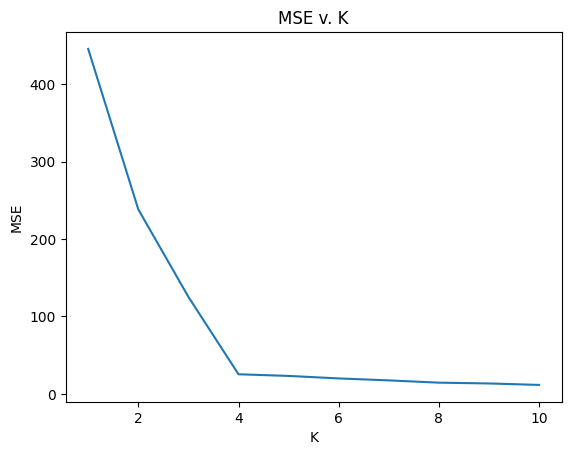

In [15]:
MSEPlot(10, dfP)

From our analysis, we can make some conclusions about KMeans clustering and how well it works as a clustering algorithm on our data. We can say that the KMeans++ algorithm is superior to the KMeans algorithm. This is clear from our experiment, where we compared the average MSE and the center locations. For a good reason, the KMeans algorithm is one of the most commonly used unsupervised learning algorithms. The elegancy and efficiency of this algorithm is impressive. Additionally, we see an even more outstanding performance when the algorithm is improved (KMeans++). The results affirm the algorithm's abilities, and we recommend that this algorithm continue to be used as frequently as possible.

## Wine Data Set

This data set contains data about 6947 Portuguese wines. It is important to note that the data is not balanced as there are 1599 red and 4898 white wines. There are 13 features in the data set, including wine labels, fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulfates, alcohol, and quality.

To start, the data is read in. The data, in this case, is stored on GitHub. The original data set was found on Kaggle: https://www.kaggle.com/datasets/ruthgn/wine-quality-data-set-red-white-wine. Next, the data is read and placed in a pandas data frame, allowing us to work more efficiently with our data.

In [16]:
urlP = "https://raw.githubusercontent.com/wjduq/Wine_Cluster_Analysis/main/wine-quality-white-and-red.csv"
rawWine = pd.read_csv(urlP, sep = ",")
rawWine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Using the info() function, we can see a very basic of our data. Crucially, we can see that we are not missing any data. Below is the distribution of the types of wine (red and white). There is not an even distribution of the types of wine, with there being significantly more whites than reds in our data set.

In [17]:
rawWine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [18]:
rawWine["type"].value_counts() #We know that there is not an even distribution of the classes

white    4898
red      1599
Name: type, dtype: int64

## Clean and Transforming Data

The first thing we need to do is check if any cleaning or transformation is needed. Of course, these things should not be done without thought as it increases the risk of adding human bias to the problem. However, feature scaling is necessary because many features have very different ranges. This can be seen in the boxplot below:

<Axes: >

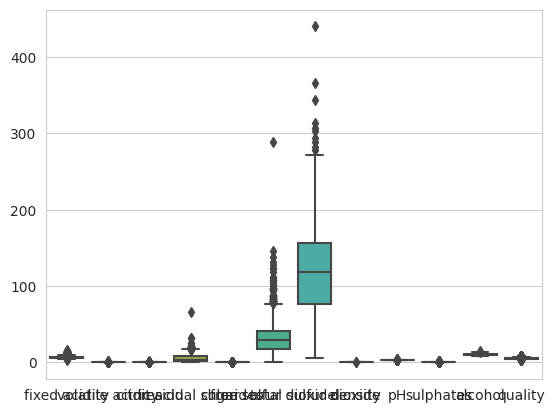

In [19]:
sn.set_style("whitegrid")
sn.boxplot(data = rawWine)

Because of the different ranges, we need to conduct feature scaling. Either standardization or normalization would have been appropriate in this context. However, we chose standardization because standardization is less susceptible to outliers. Below is a function named standardizer used to standardize the data. Once that function is described, we use it to standardize the data. The results can be seen within the first four rows of the newly standardized data set. Notice the change in values. With the newly scaled data, we can continue with our experiment.

- A quick note on standardization: To standardize a value, we subtract by the mean and divide by the standard deviation

In [20]:
def standardizer(df, attributes):
  """
Author: William Duquette

The function takes a dataset and standardizes the listed attributes
PARAMETERS:
df - a pandas dataframe
The columns are attributes and the rows are samples.

attributres -  a list of the attributres within the given pandas df that you would like to standardize

RETURN VALUE: dfTrain, dfTest
The function has no return value. This function edits the pandas dataframe that is entered and standardizes the columns that are entered
  """

  # Feature Scaling: Using standardization because variables are on different scales
  for attr in attributes:
    df[attr] = (df[attr] - df[attr].mean())/df[attr].std()

In [21]:
attributes = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol", "quality"]

standardizer(rawWine, attributes) #Standardize the desired columns
rawWine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,-0.166076,-0.423150,0.284664,3.206682,-0.314951,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449,0.207983
1,white,-0.706019,-0.240931,0.147035,-0.807775,-0.200775,-0.931035,0.287595,-0.232314,0.506876,-0.277330,-0.831551,0.207983
2,white,0.682405,-0.362411,0.559923,0.306184,-0.172231,-0.029596,-0.331634,0.134515,0.258100,-0.613338,-0.328496,0.207983
3,white,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983
4,white,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983


Once we have transformed the data, getting some preliminary knowledge of the data can be helpful. This is not particularly useful in building a model, but it gives us some basic data knowledge.

In [22]:
rawWine.describe() # Short describtion of the data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6497.000000,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03,6.497000e+03
mean,2.099803e-16,-2.449770e-16,3.499672e-17,3.499672e-17,-3.499672e-17,-8.749179e-17,0.000000,-3.517170e-15,2.720995e-15,2.099803e-16,-8.399212e-16,-2.821610e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.634386e+00,-1.577208e+00,-2.192664e+00,-1.017956e+00,-1.342536e+00,-1.663455e+00,-1.941631,-2.529997e+00,-3.100376e+00,-2.091774e+00,-2.089189e+00,-3.227439e+00
25%,-6.288845e-01,-6.661100e-01,-4.722972e-01,-7.657389e-01,-5.147590e-01,-7.620156e-01,-0.685480,-7.858922e-01,-6.748102e-01,-6.805395e-01,-8.315512e-01,-9.371575e-01
50%,-1.660764e-01,-3.016707e-01,-5.940918e-02,-5.135217e-01,-2.578628e-01,-8.593639e-02,0.039904,6.448391e-02,-5.287017e-02,-1.429263e-01,-1.608107e-01,2.079830e-01
75%,3.738663e-01,3.664680e-01,4.911081e-01,5.584015e-01,2.559297e-01,5.901428e-01,0.712210,7.647937e-01,6.312639e-01,4.618885e-01,6.776148e-01,2.079830e-01
max,6.698910e+00,7.533774e+00,9.230570e+00,1.268585e+01,1.584097e+01,1.456245e+01,5.736815,1.476765e+01,4.922650e+00,9.870119e+00,3.695947e+00,3.643405e+00


## Data Analysis and Preparation

Analyzing data when working in an unsupervised environment can sometimes be challenging. However, creating some basic data visualizations is still helpful to see how variables relate.

However, before doing that, we must prepare our data for the KMeans Algorithm. In this case, we have the labels for our data. Therefore, we are removing the labels (we do not want this to be used in the clustering algorithm for obvious reasons) and bringing them back later to run tests on how well our KMeans algorithm performed on grouping similar objects (different kinds of wine).

In [23]:
rawWineUpdate = rawWine.iloc[: , 1:]
rawWineUpdate

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.166076,-0.423150,0.284664,3.206682,-0.314951,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449,0.207983
1,-0.706019,-0.240931,0.147035,-0.807775,-0.200775,-0.931035,0.287595,-0.232314,0.506876,-0.277330,-0.831551,0.207983
2,0.682405,-0.362411,0.559923,0.306184,-0.172231,-0.029596,-0.331634,0.134515,0.258100,-0.613338,-0.328496,0.207983
3,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983
4,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783154,1.581266,-1.642146,-0.723703,0.969530,0.083083,-1.269324,0.067819,1.439786,0.327485,0.006874,-0.937157
6493,-1.014558,1.277566,-1.504517,-0.681666,0.170298,0.477463,-1.145479,0.141185,1.875144,1.537115,0.593772,0.207983
6494,-0.706019,1.034607,-1.298073,-0.660648,0.569914,-0.085936,-1.340094,0.347943,1.253204,1.469913,0.426087,0.207983
6495,-1.014558,1.854595,-1.366888,-0.723703,0.541370,0.083083,-1.269324,0.257903,2.186114,1.201107,-0.244653,-0.937157


In [24]:
wineLabels = rawWine.iloc[:, 0] # Extract labels to see if clustering properly groups values
wineLabels

0       white
1       white
2       white
3       white
4       white
        ...  
6492      red
6493      red
6494      red
6495      red
6496      red
Name: type, Length: 6497, dtype: object

Scatter Plot Matrix:
- We would like to see the distribution of each variable. This can be seen along the diagonal of the matrix.
- We also want to see how closely the variables correlate (we will also look at this same thing using the correlation matrix).
- There is nothing particularly of interest for this scatter plot matrix and nothing concerning. There might be small amounts of multicollinearity, but that can be more closely examined in the correlation matrix.
- Note: Although not necessary for this project under strict terms, it is always helpful for all parties involved to get a visual representation of the data we are working with.

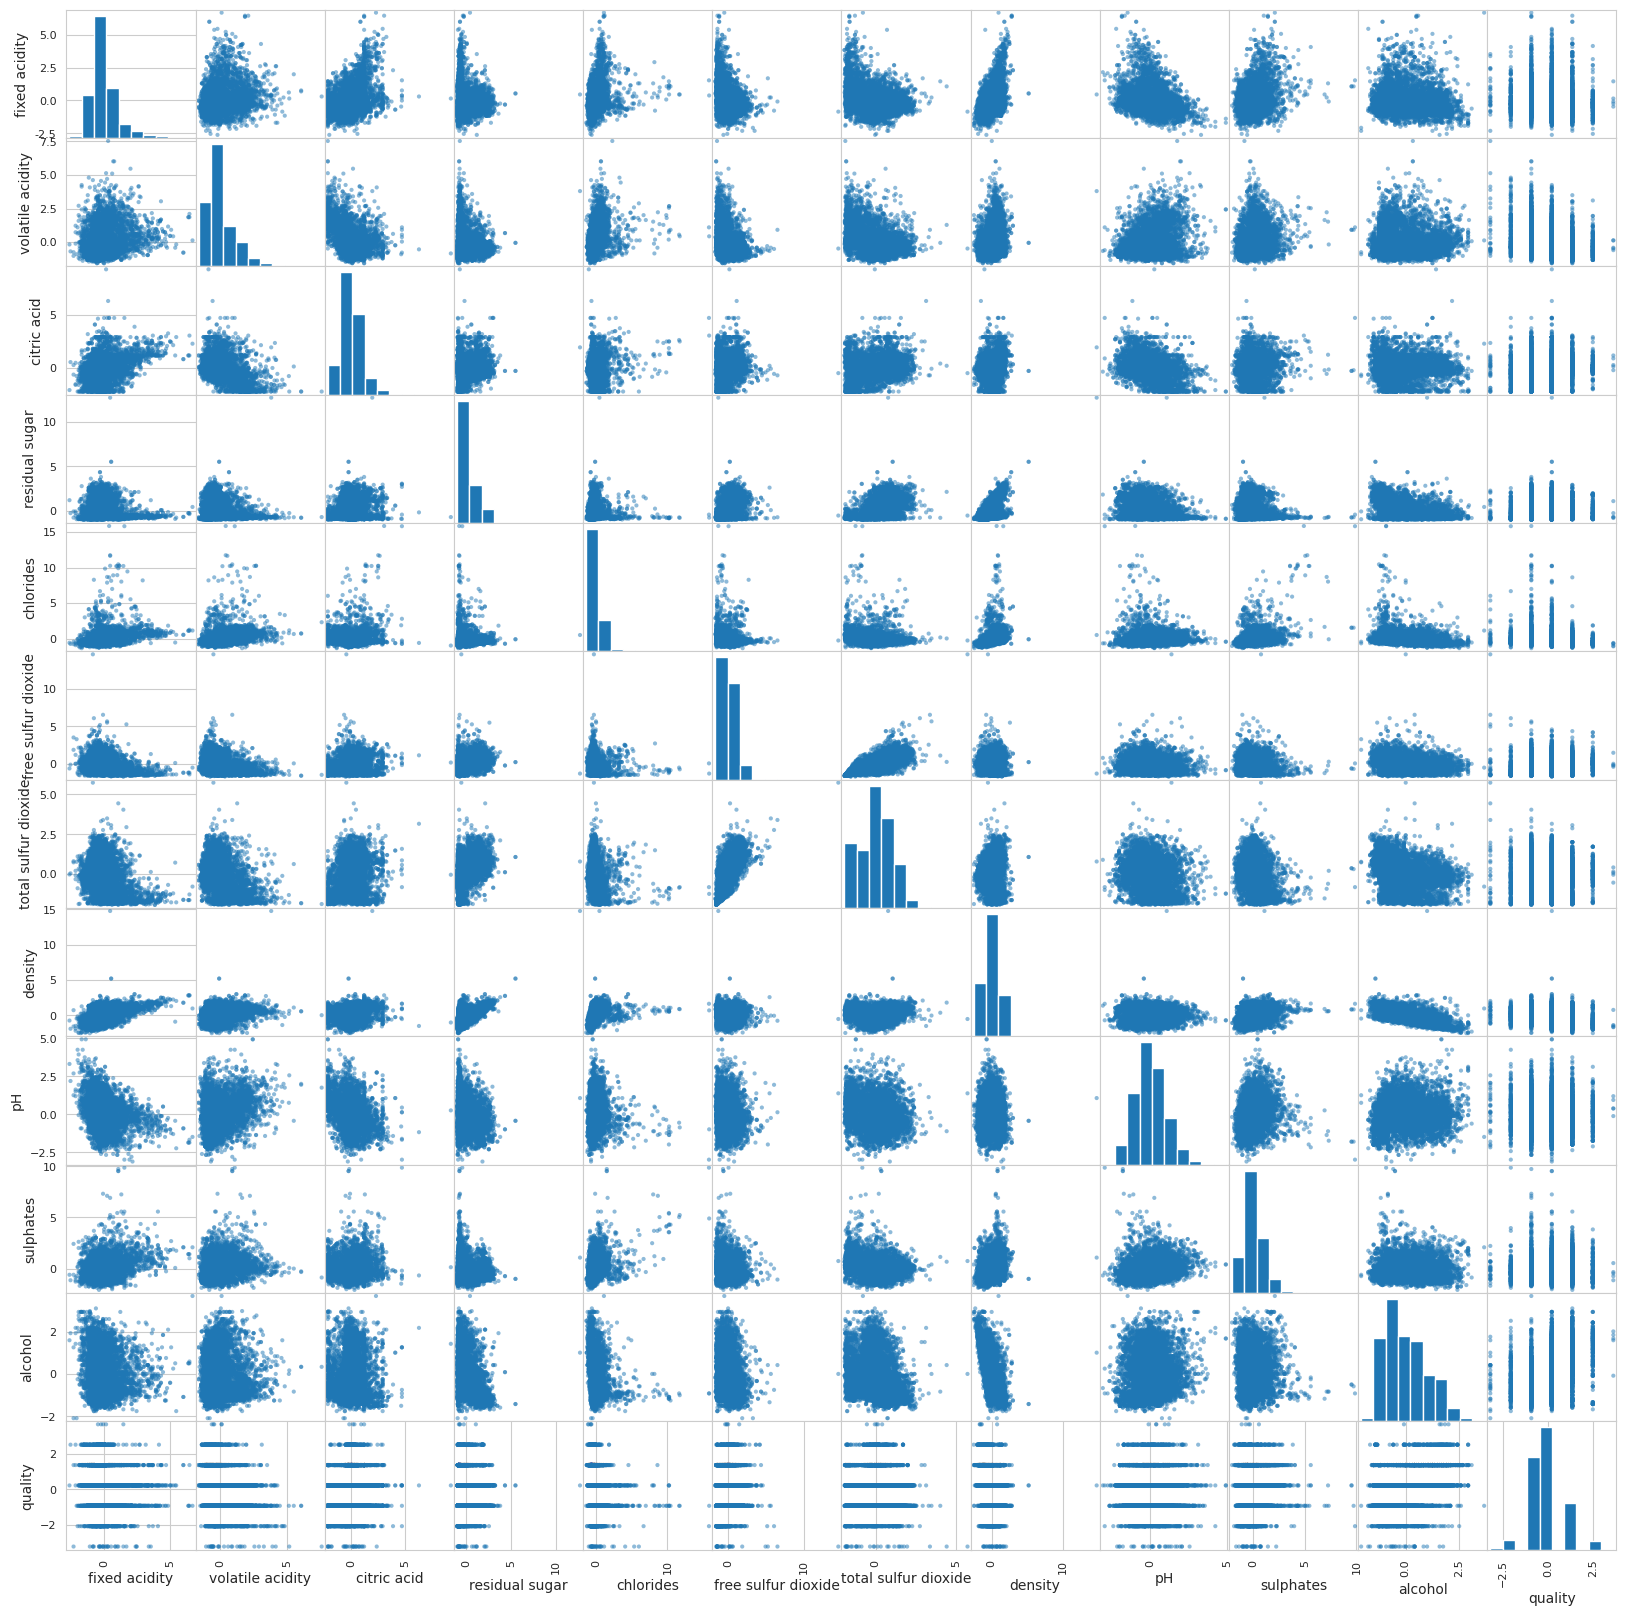

In [25]:
scatter_matrix(rawWineUpdate[attributes], figsize = (20,20)); #scatter matrix

In the same vein as above, we can make a correlation matrix. This is done using the pandas .corr() function (in this case, we have chosen the Pearson Method). After this calculation, we can create a correlation matrix using seaborn (plotting library in python). This allows us to see the relationship between values more concretely. For those who wish to see an example of correlation, this link has some good information: https://www.scribbr.com/statistics/correlation-coefficient/.

Below we can see the correlation matrix for the data set.

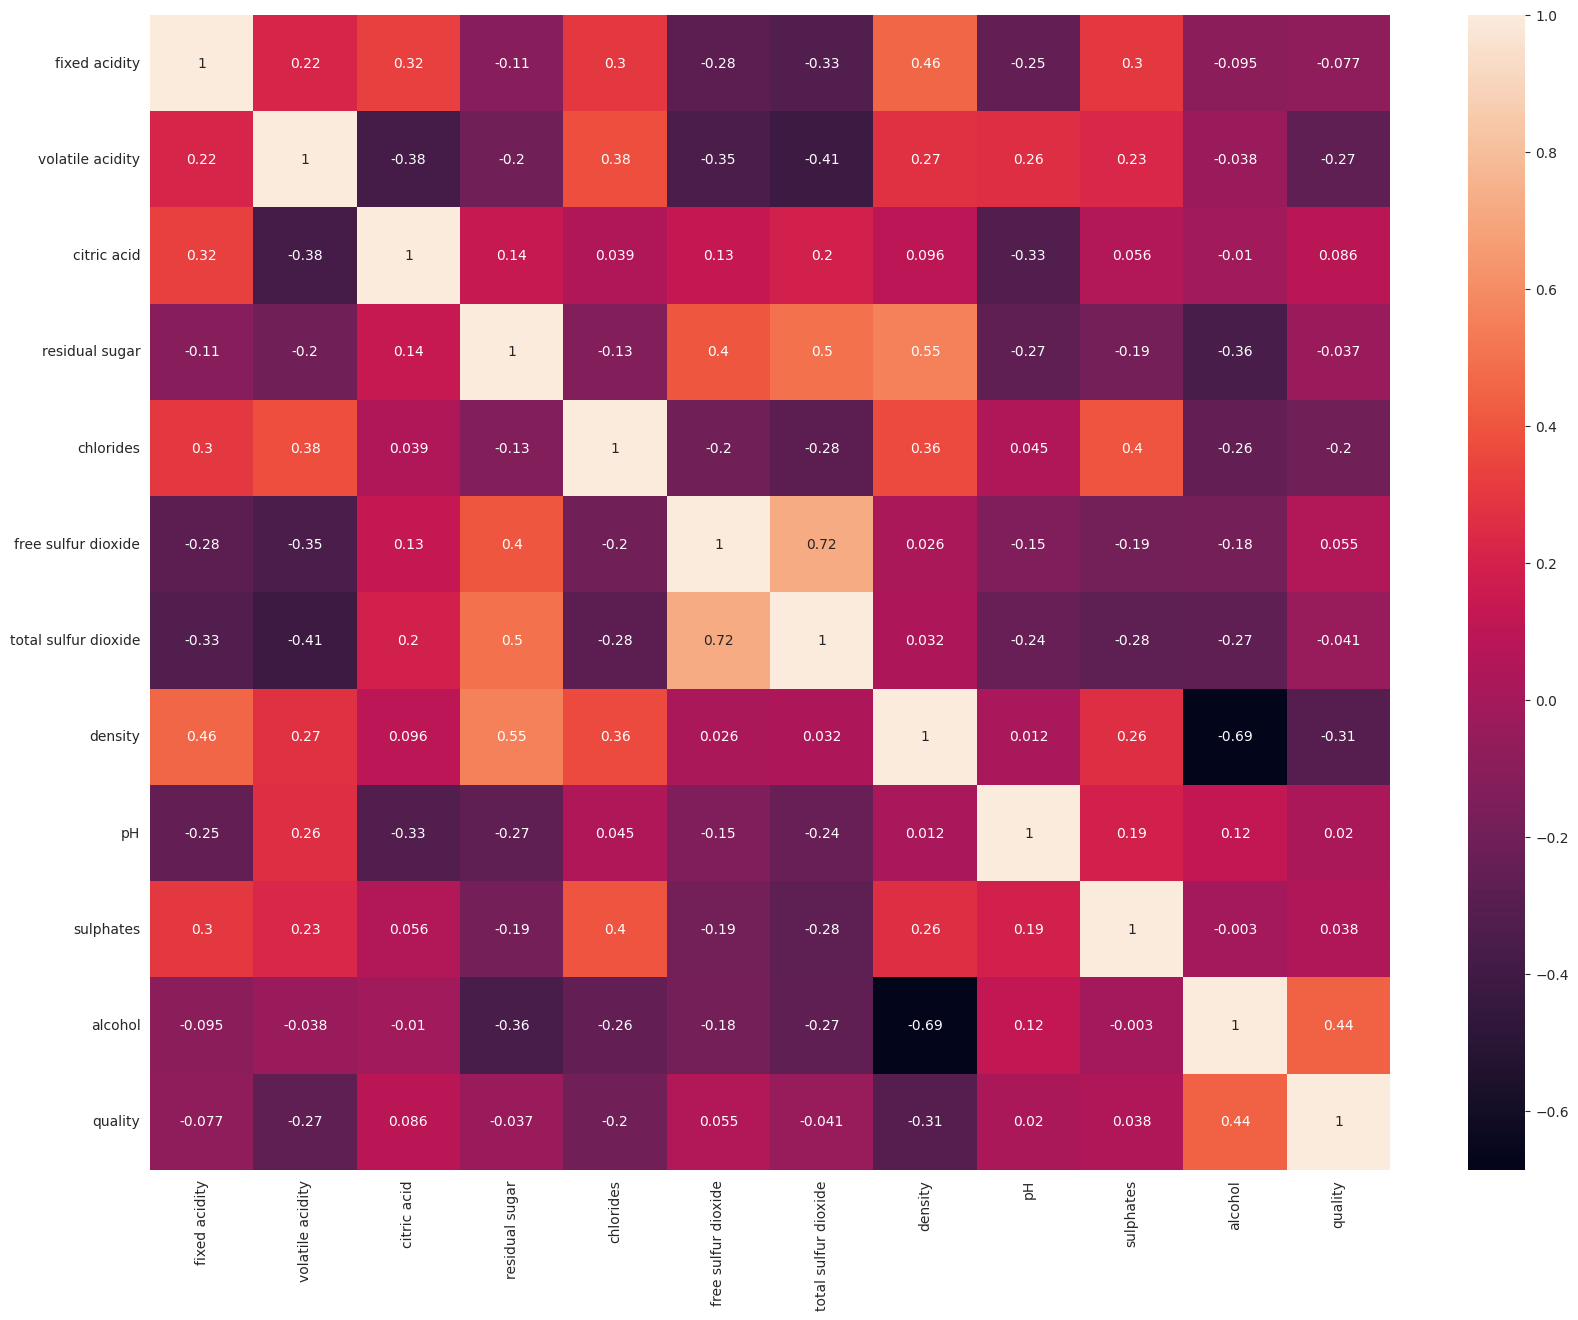

In [26]:
plt.figure(figsize = (20,15))
corrMatrix = rawWineUpdate.corr(method = "pearson")
sn.heatmap(corrMatrix, annot = True) #correlation matrix using seaborn
plt.show()

## Create Clusters

Now we can finally create our clusters. As previously mentioned, it is best to create a plot (MSE v K) that allows us to see the best value of k to choose. Typically, you want to find the elbow of the graph and select that as the value of K.

Below we run our MSEPlot() function that implements the KMeans++ algorithm on multiple values of k and creates a plot to see the elbow.

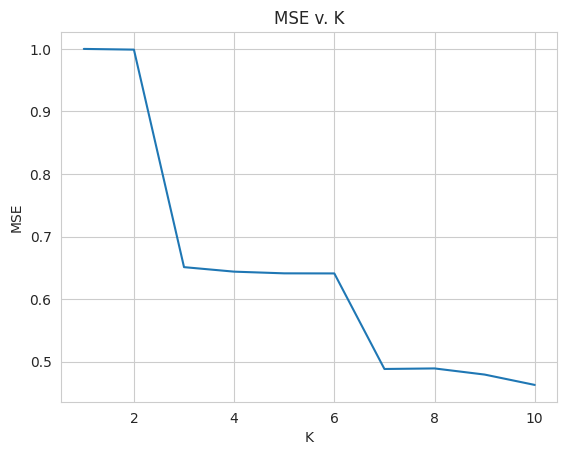

In [27]:
MSEPlot(10, rawWineUpdate)

Note: The MSE v k plot will vary each time the code is run. When you run the code book, you may see a different value of k. If you would like to change the code, adjust the value of k passed into the KMeansP Algorithm

We see that three and seven are the elbows of the graph; we select three as the number of clusters used. It may seem odd that the optimal value of k is not two, given we have red and white wines in our data set, which is a critical point to discuss. Although we only have two wine types (red and white), we could imagine a situation with multiple subgroups within each wine type. Although all the wines in the data set are within an overarching wine-type group, it could be challenging to group all of the wines in two groups together, given how different subgroups may be. This is not necessarily the case, but it is a crucial thought experiment to help illustrate why more than two clusters may be necessary.

Once we run our algorithm, we specify each row's cluster. Additionally, after the clustering, we add the wine labels back into the data set.

In [28]:
centers, MSE, iterations, clusters = kMeansP(3, rawWineUpdate) # Change number of clusters if desired

# Add clustering data to pandas data frame
rawWineUpdate["Cluster"] = clusters
rawWineUpdate["Cluster"] = rawWineUpdate["Cluster"].astype('int')

rawWineUpdate["Labels"] = wineLabels # Add wine labels into data set

rawWineUpdate # Updated data set (with labels and clusters)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Cluster,Labels
0,-0.166076,-0.423150,0.284664,3.206682,-0.314951,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449,0.207983,0,white
1,-0.706019,-0.240931,0.147035,-0.807775,-0.200775,-0.931035,0.287595,-0.232314,0.506876,-0.277330,-0.831551,0.207983,0,white
2,0.682405,-0.362411,0.559923,0.306184,-0.172231,-0.029596,-0.331634,0.134515,0.258100,-0.613338,-0.328496,0.207983,0,white
3,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983,0,white
4,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983,0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783154,1.581266,-1.642146,-0.723703,0.969530,0.083083,-1.269324,0.067819,1.439786,0.327485,0.006874,-0.937157,1,red
6493,-1.014558,1.277566,-1.504517,-0.681666,0.170298,0.477463,-1.145479,0.141185,1.875144,1.537115,0.593772,0.207983,1,red
6494,-0.706019,1.034607,-1.298073,-0.660648,0.569914,-0.085936,-1.340094,0.347943,1.253204,1.469913,0.426087,0.207983,1,red
6495,-1.014558,1.854595,-1.366888,-0.723703,0.541370,0.083083,-1.269324,0.257903,2.186114,1.201107,-0.244653,-0.937157,1,red


In [29]:
# See the number of points per cluster
rawWineUpdate["Cluster"].value_counts()

0    4829
1    1667
2       1
Name: Cluster, dtype: int64

Since we are working with such high dimensional data, showing our results visually can be very challenging. It is impossible to make a visualization that shows more than 3 or 4 dimensions (color could be used to show the fourth dimension in some cases). So instead, we will fall back on our scatter plot matrix. However, this time each point will be colored with the cluster that it is in.

Since we are working with such high dimensional data, showing our results visually can be very challenging. It is impossible to make a visualization that shows more than 3 or 4 dimensions (color could be used to show the fourth dimension in some cases). So instead, we will fall back on our scatter plot matrix. However, this time each point will be colored with the cluster that it is in. In this example, k was chosen as three, but looking at the plot, only two colors are visible. That is because the third cluster is tiny and, therefore, not visible in most plots. Nevertheless, a third color can be seen in some of the plots. Example: three colors are visible in the volatile acidity v density entry. It is important to remember that if this code is rerun (restart and run all), it is likely that different results will be seen.

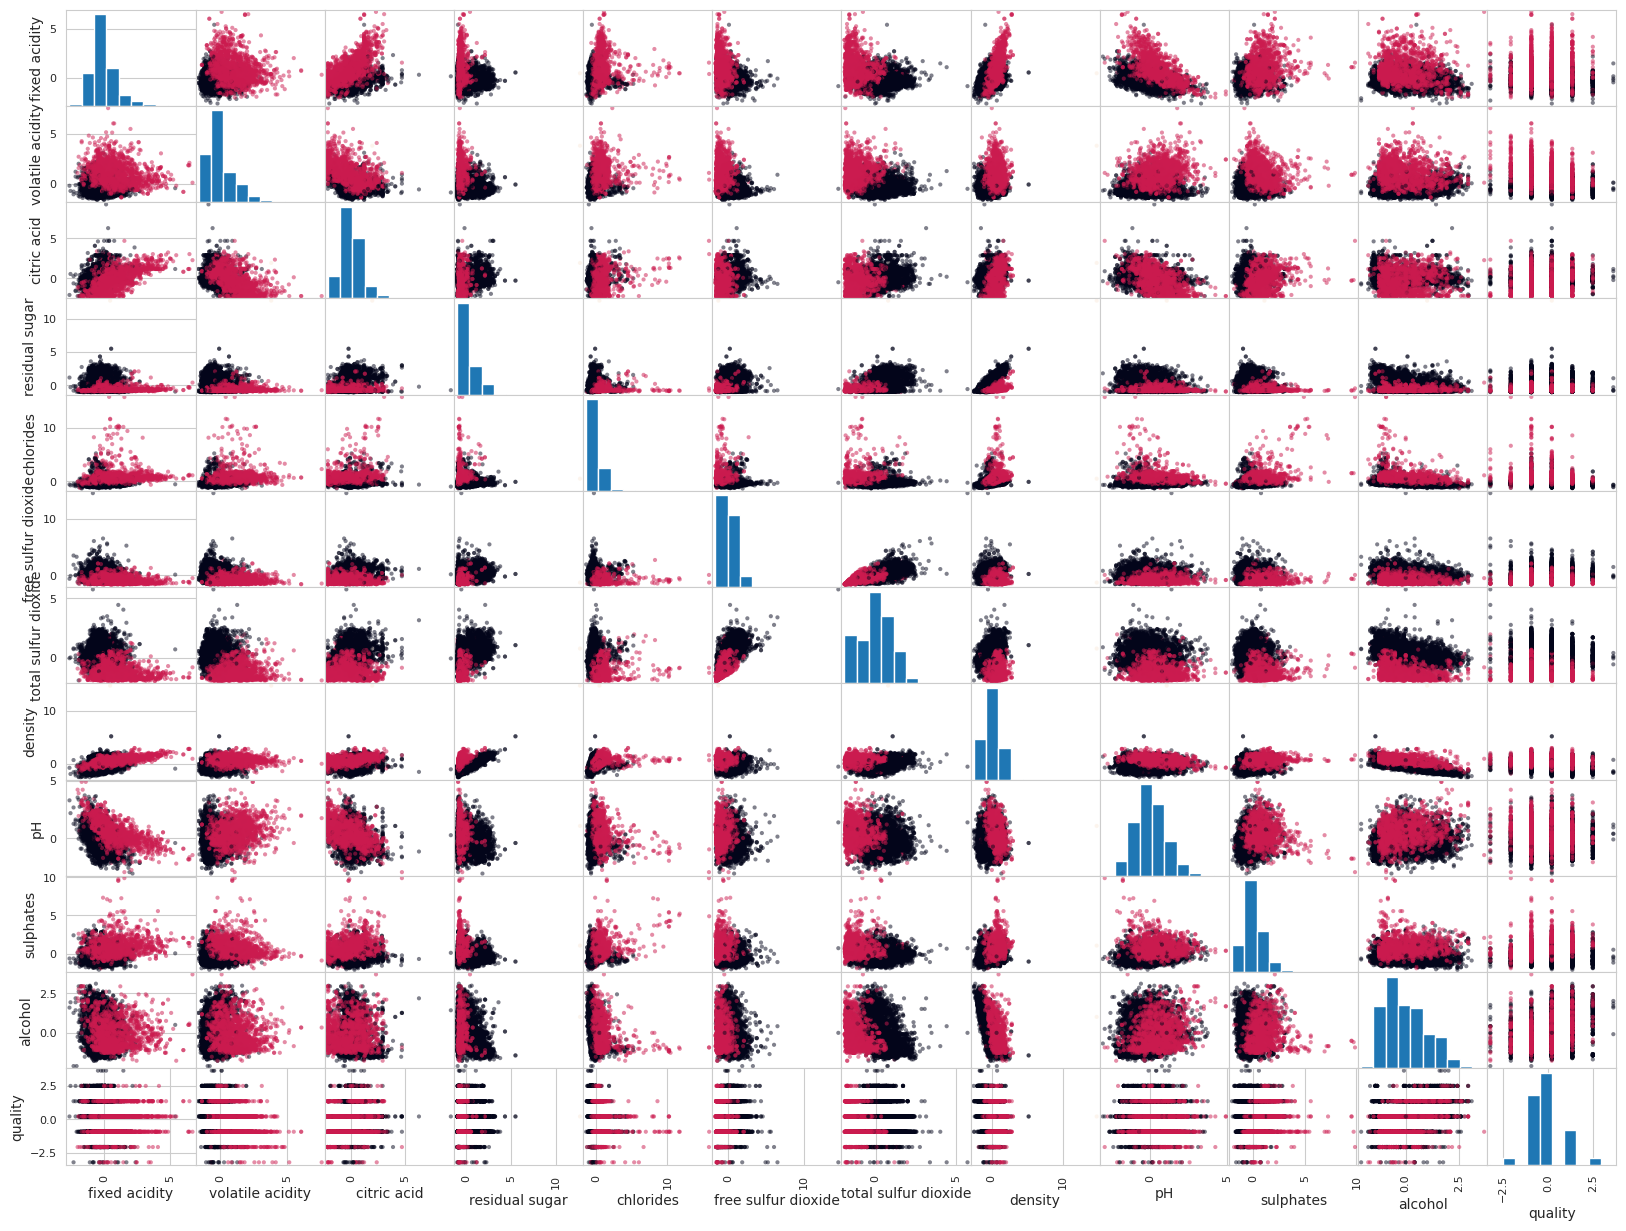

In [30]:
scatter_matrix(rawWineUpdate[attributes], figsize = (20,15), c = rawWineUpdate["Cluster"]); #scatter matrix

## Cluster Impurity

Since we are working with somewhat unsupervised data, we cannot traditionally get an "accuracy" measurement. Nevertheless, we want to see how correct our clustering is. In this case, we will calculate the purity of our clusters. The Gini Impurity will tell us how different our clusters are from the pure clustering. Furthermore, it will tell us how "far" we are from pure clustering.

Let's walk through two examples to understand what is considered a good Gini value. In both cases, we will assume that a cluster has 100 points and two possible classes (red and white).

- If the cluster contains fifty red and fifty white points (so 50/50), we would have a Gini Impurity of 0.5.

- If the cluster contains 90 red and ten white, we would have a Gini Impurity of 0.18.

To conclude our example, the closer to zero, the more pure the cluster.

Note: Before we analyze the results, it is essential to remember that each time this notebook is run, it is likely that there will be a different result.

In our case, we see low impurity values, which is encouraging. We can see the results below when $k$ is chosen as three. The table below contains information on the three clusters and the Gini Impurity. It might seem odd that there is a cluster with one data point. However, this is for a good reason. One particular white wine is a massive outlier and cannot feasibly be clustered well with the other white wines. If we ignore the elbow plot and choose 2 clusters, the clusters become significantly less pure.

- Cluster 1: 25 Red, 4804 White, 4829 Total, Gini Impurity: 0.0103
- Cluster 2: 0 Red, 1 White, 1 Total, Gini Impurity: 0.0
- Cluster 3: 1574 Red, 93 White , 1667 Total, Gini Impurity: 0.105

In [31]:
# Calculate the gini inpurity of each cluster
wines = ["white", "red"]

clusters = rawWineUpdate.Cluster
sumRed = 0
sumWhite = 0

for cluster in range(len(clusters.value_counts())):
  sumRed = 0
  sumWhite = 0
  currentK = rawWineUpdate.loc[rawWineUpdate['Cluster'] == cluster]
  for index, row in currentK.iterrows():
    if row["Labels"] == "white":
      sumWhite += 1
    else:
      sumRed += 1

  print(1 - ((sumRed/len(currentK))**2 + (sumWhite/len(currentK))**2))

0.010300506778929908
0.10535289462803288
0.0


### What if We Remove The Outlier?

It can be helpful to remove extreme outliers to see the algorithm's performance. Outliers should only be permanently removed from the experiment if the point is not representative of the data. Removing outliers should be done sparingly, as it can introduce bias. But, it can be helpful to remove the outlier temporarily to see the algorithm's performance while still noting the results we have seen, as we have.

In this case, we see performance differences after removing the extreme white wine in our data set. We first see that only two clusters are recommended by our elbow plot.

In [32]:
for index, row in rawWineUpdate.iterrows():
  if row["Cluster"] == 1:
    print(row) # part of sole cluster with one element

rawWineUpdate.drop(2781, inplace = True) # Remove row with outlier

Streaming output truncated to the last 5000 lines.
alcohol                 0.677615
quality                 0.207983
Cluster                        1
Labels                       red
Name: 6156, dtype: object
fixed acidity          -0.320346
volatile acidity        1.824225
citric acid            -2.192664
residual sugar         -0.576576
chlorides               1.911483
free sulfur dioxide    -0.874695
total sulfur dioxide   -1.463939
density                  0.22789
pH                      1.377592
sulphates               0.663493
alcohol                 0.677615
quality                 0.207983
Cluster                        1
Labels                       red
Name: 6157, dtype: object
fixed acidity           1.068078
volatile acidity        1.793855
citric acid             2.486733
residual sugar         -0.765739
chlorides                9.90381
free sulfur dioxide    -0.649336
total sulfur dioxide   -1.057017
density                 0.541362
pH                     -1.234556
sulpha

In [33]:
wineOutlierRemove = rawWineUpdate.iloc[:, : -2] # Remove labels and clusters from data frame
labels = rawWineUpdate.iloc[:, 13] # save labels

Below is the Elbow Plot for the data with the outliers removed. Notice that only two clusters are recommended.

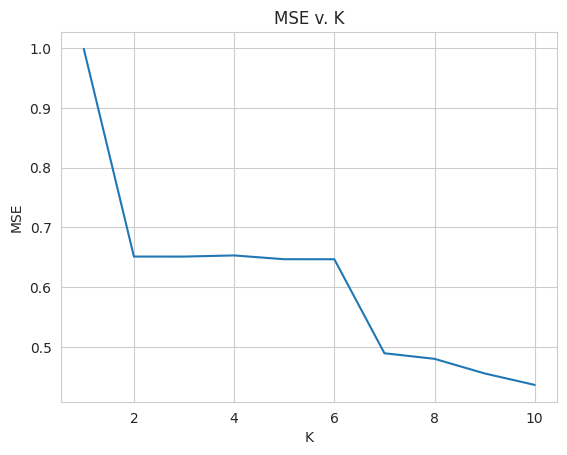

In [34]:
MSEPlot(10, wineOutlierRemove)

Like above, we specify each row's cluster in the data frame. Additionally, after the clustering, we add the wine labels back into the data set.

In [35]:
centers, MSE, iterations, clusters = kMeansP(2, wineOutlierRemove) # Change number of clusters if desired

# Add clustering data to pandas data frame
wineOutlierRemove["Cluster"] = clusters
wineOutlierRemove["Cluster"] = wineOutlierRemove["Cluster"].astype('int')

wineOutlierRemove["Labels"] = labels # Add wine labels into data set

wineOutlierRemove # Updated data set (with labels and clusters)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Cluster,Labels
0,-0.166076,-0.423150,0.284664,3.206682,-0.314951,0.815503,0.959902,2.102052,-1.358944,-0.546136,-1.418449,0.207983,0,white
1,-0.706019,-0.240931,0.147035,-0.807775,-0.200775,-0.931035,0.287595,-0.232314,0.506876,-0.277330,-0.831551,0.207983,0,white
2,0.682405,-0.362411,0.559923,0.306184,-0.172231,-0.029596,-0.331634,0.134515,0.258100,-0.613338,-0.328496,0.207983,0,white
3,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983,0,white
4,-0.011807,-0.666110,0.009405,0.642474,0.056121,0.928182,1.242978,0.301255,-0.177258,-0.882144,-0.496181,0.207983,0,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,-0.783154,1.581266,-1.642146,-0.723703,0.969530,0.083083,-1.269324,0.067819,1.439786,0.327485,0.006874,-0.937157,1,red
6493,-1.014558,1.277566,-1.504517,-0.681666,0.170298,0.477463,-1.145479,0.141185,1.875144,1.537115,0.593772,0.207983,1,red
6494,-0.706019,1.034607,-1.298073,-0.660648,0.569914,-0.085936,-1.340094,0.347943,1.253204,1.469913,0.426087,0.207983,1,red
6495,-1.014558,1.854595,-1.366888,-0.723703,0.541370,0.083083,-1.269324,0.257903,2.186114,1.201107,-0.244653,-0.937157,1,red


In [36]:
# See the number of points per cluster
wineOutlierRemove["Cluster"].value_counts()

0    4829
1    1667
Name: Cluster, dtype: int64

Now we want to check the Gini Impurity of our clustering after the outlier is removed. Recall, we only have two clusters. Interestingly, the purity of our clusters is not affected by the removal of the outlier. The purity values are the same, suggesting that this white wine was extreme and has no effect on the clustering of our other data points. See the updated values below. Notice that it is exactly the same as the previous values, with the exception of the outlier we removed.

- Cluster 1: 25 Red, 4804 White, 4829 Total, Gini Impurity: 0.0103
- Cluster 2: 1574 Red, 93 White, 1667 Total, Gini Impurity: 0.105

In [37]:
wines = ["white", "red"]

clusters = wineOutlierRemove.Cluster
sumRed = 0
sumWhite = 0

for cluster in range(len(clusters.value_counts())):
  sumRed = 0
  sumWhite = 0
  currentK = wineOutlierRemove.loc[wineOutlierRemove['Cluster'] == cluster]
  for index, row in currentK.iterrows():
    if row["Labels"] == "white":
      sumWhite += 1
    else:
      sumRed += 1

  print(1 - ((sumRed/len(currentK))**2 + (sumWhite/len(currentK))**2))

0.010300506778929908
0.10535289462803288


## Conclusion

In this notebook, we analyzed a wine data set using KMeans clustering and sought to determine whether the clusters created were pure. As we have seen, it is clear that the KMeans algorithm works well for clustering wine data points in such a way that keeps the clusters relatively pure, especially once the outlier is removed. This is an important finding as it allows us to use the KMeans algorithm more confidently because we can have faith that this algorithm will cluster well.